<a href="https://colab.research.google.com/github/pradyumna4998/Intro-to-ML/blob/main/Naive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install imbalanced-learn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns



ERROR: Operation cancelled by user
Original class distribution: [39495 10324  2766]
Class distribution after SMOTE: [31596 31596 31596]
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 7 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 8 are removed. Consider decreasing the number of bins.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 9 are removed. Consider decreasing the number of bins.
  warnings.warn(



Model: GaussianNB
Best Params: {'var_smoothing': 0.03393221771895328}
Best CV Score: 0.431679299879473
Test Accuracy: 0.4642
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Model: MultinomialNB
Best Params: {'alpha': 5.0}
Best CV Score: 0.36307338172008463
Test Accuracy: 0.3945
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Model: BernoulliNB
Best Params: {'alpha': 0.1}
Best CV Score: 0.38513327002883907
Test Accuracy: 0.5483

Best model: BernoulliNB with Test Accuracy: 0.5483

Final Best Model Training Metrics:
Accuracy: 0.3846
Precision: 0.3872
Recall: 0.3846
F1 Score: 0.3593

Final Best Model Testing Metrics:
Accuracy: 0.5483
Precision: 0.6053
Recall: 0.5483
F1 Score: 0.5738

Classification Report (Testing):
                 precision    recall  f1-score   support

         Normal       0.75      0.68      0.71      7899
Moderate Stress       0.19      0.17      0.18      2065
     Depression       0.05      0.14      0.07       553

       accuracy      

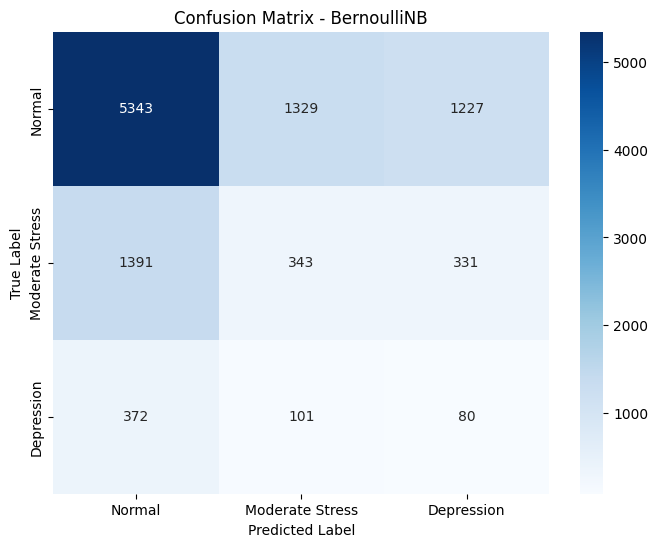

In [ ]:
!pip install imbalanced-learn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, KBinsDiscretizer
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score, f1_score)
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
cleaned_dataset_path = '/content/drive/My Drive/ML/data.csv'
data = pd.read_csv(cleaned_dataset_path)

# Define features and target
features = [
    'Heart_Rate',
    'Blood_Pressure_Systolic',
    'Blood_Pressure_Diastolic',
    'Skin_Temperature',
    'Respiration_Rate',
    'Sleep_Duration',
    'Activity_Levels',
    'Mood',
    'Stress_Level',
    'Resilience_Factors'
]
target = 'Mental_Health_Status'

X = data[features]
y = data[target]

# Handle missing values
X = X.fillna(X.median())

# Encode categorical features
categorical_columns = ['Mood', 'Stress_Level']
for col in categorical_columns:
    if X[col].dtype == 'object' or X[col].dtype.name == 'category':
        X[col] = LabelEncoder().fit_transform(X[col])

# Encode target
if y.dtype == 'object' or y.dtype.name == 'category':
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    class_names = label_encoder.inverse_transform([0, 1, 2])
else:
    y_encoded = y.astype(int).values
    class_names = ['Normal', 'Moderate Stress', 'Depression']

# Check original class distribution
print("Original class distribution:", np.bincount(y_encoded))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=100, stratify=y_encoded
)

# Apply SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:", np.bincount(y_train_res))

# Try discretizing features for MultinomialNB and BernoulliNB
# This may help if continuous features are not well-modeled by NB.
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
X_train_discrete = discretizer.fit_transform(X_train_res)
X_test_discrete = discretizer.transform(X_test)

# Feature selection
# Try selecting top 8 features as an example. Adjust as needed.
selector = SelectKBest(score_func=f_classif, k=8)
X_train_selected = selector.fit_transform(X_train_discrete, y_train_res)
X_test_selected = selector.transform(X_test_discrete)

# We'll try three NB variants and pick the best
models = {
    'GaussianNB': (GaussianNB(), {'var_smoothing': np.logspace(0, -9, num=50)}),
    'MultinomialNB': (MultinomialNB(), {'alpha': [0.1, 0.5, 1.0, 5.0]}),
    'BernoulliNB': (BernoulliNB(), {'alpha': [0.1, 0.5, 1.0, 5.0]})
}

best_acc = 0
best_model = None
best_name = None

for name, (model, params) in models.items():
    grid = GridSearchCV(
        estimator=model,
        param_grid=params,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train_selected, y_train_res)
    print(f"\nModel: {name}")
    print("Best Params:", grid.best_params_)
    print("Best CV Score:", grid.best_score_)

    # Test on the test set
    y_pred_test = grid.predict(X_test_selected)
    test_acc = accuracy_score(y_test, y_pred_test)
    print(f"Test Accuracy: {test_acc:.4f}")

    if test_acc > best_acc:
        best_acc = test_acc
        best_model = grid.best_estimator_
        best_name = name

print(f"\nBest model: {best_name} with Test Accuracy: {best_acc:.4f}")

# Evaluate best model in detail
y_pred_train = best_model.predict(X_train_selected)
y_pred_test = best_model.predict(X_test_selected)

metrics_train = {
    "Accuracy": accuracy_score(y_train_res, y_pred_train),
    "Precision": precision_score(y_train_res, y_pred_train, average='weighted', zero_division=0),
    "Recall": recall_score(y_train_res, y_pred_train, average='weighted', zero_division=0),
    "F1 Score": f1_score(y_train_res, y_pred_train, average='weighted', zero_division=0)
}

metrics_test = {
    "Accuracy": accuracy_score(y_test, y_pred_test),
    "Precision": precision_score(y_test, y_pred_test, average='weighted', zero_division=0),
    "Recall": recall_score(y_test, y_pred_test, average='weighted', zero_division=0),
    "F1 Score": f1_score(y_test, y_pred_test, average='weighted', zero_division=0)
}

print("\nFinal Best Model Training Metrics:")
for metric, value in metrics_train.items():
    print(f"{metric}: {value:.4f}")

print("\nFinal Best Model Testing Metrics:")
for metric, value in metrics_test.items():
    print(f"{metric}: {value:.4f}")

print("\nClassification Report (Testing):")
print(classification_report(y_test, y_pred_test, target_names=class_names, zero_division=0))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title(f"Confusion Matrix - {best_name}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
